In [ ]:
# # Set up and embed documents, then upsert to Pinecone
# from pinecone import Pinecone
# from openai import OpenAI
# import os
# import json
# from tqdm import tqdm

# client = OpenAI(
#     api_key=os.getenv("OPENAI_API_KEY")
# )
# pc = Pinecone(
#     api_key='pcsk_66Rsf4_5bSnMLDGg8ccokMvXQexDisztbN9EBEApmRbHrgHZsTKF6M8Vr8v474JMuyAKfk'
# )

# index = pc.Index("connect-chatbot-mq-1")

# with open("mq_connect_data_1.json", "r", encoding="utf-8") as f:
#     data = json.load(f)
    
# #Embed and upsert
# for i, item in tqdm(enumerate(data), total=len(data), desc="Embedding & upserting"):
#     text = item['text']
#     url = item['url']
    
#     resp = client.embeddings.create(
#         model = 'text-embedding-3-small',
#         input=text
#     )
#     vector = resp.data[0].embedding
    
#     index.upsert([
#         {
#             "id": f"doc-{i}",
#             "values": vector,
#             "metadata": {"url": url, "text": text}
#         }
#     ])
    

Embedding & upserting: 100%|██████████| 170/170 [02:11<00:00,  1.30it/s]


In [33]:
# Import necessary libraries and set up 
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA

llm = ChatOpenAI(model="gpt-5-mini")

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

pc = Pinecone(
    api_key='pcsk_66Rsf4_5bSnMLDGg8ccokMvXQexDisztbN9EBEApmRbHrgHZsTKF6M8Vr8v474JMuyAKfk'
)
index = pc.Index("connect-chatbot-mq-1")
vector_store = PineconeVectorStore(embedding=embeddings, index=index)
retriever = vector_store.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5, "k": 3})

In [35]:

# qa = RetrievalQA.from_chain_type(
#     llm=llm,
#     retriever=retriever,
#     return_source_documents=True
# )
# query = "I am an international student. I have enrolled in a unit but now I want to change to another unit. How can I do this?"
# res = qa.invoke({"query": query})

# print("Answer:", res['result'])
# print("Sources:", [doc.metadata["url"] for doc in res["source_documents"]])

In [ ]:
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.prompts import PromptTemplate

retrieval_qa_chat_prompt_template = PromptTemplate(
    input_variables=["input", "context"],
    template="""
You are a helpful assistant that helps students find information about Macquarie University. 
Only answer questions related to Macquarie University. Assume the user is asking about Macquarie University's policy.
Answer any use questions based solely on the context below:

<context>
{context}
</context>

Question: {input}
Answer concisely and provide relevant contact info if applicable. If you don't know the answer, just say "Please contact Service Connect for further assistance". Do not try to make up an answer.
"""
)

combine_docs_chain = create_stuff_documents_chain(
    llm, retrieval_qa_chat_prompt_template
)
rag_chain = create_retrieval_chain(
    vector_store.as_retriever(), combine_docs_chain)

rag_chain.invoke(
    {"input": "I have studied at another university. Can I transfer my cresits to Macquarie University?"})

{'input': 'I have studied at another university. Can I transfer my cresits to Macquarie University?',
 'context': [Document(id='doc-78', metadata={'url': 'https://connect.mq.edu.au/s/article/Previous-Macquarie-Univeristy-Student-PMQ'}, page_content="1 Oct 2024\nKnowledge\nIf you were a previous Macquarie University student and you would like to get credit for the units you have studied read the answers to frequently asked questions below.\n\nI was a previous Macquarie student and didn't complete my studies. How do I move my passed units to my new degree?\nTo move any eligible prior studies to your new course, you can apply forRecognition of Prior Learning.\nPlease readRecognition of Prior Learning FAQbefore applying.\n\nWill all of my previous Macquarie units be moved to my new degree?\nYour previous Macquarie units that contribute to the requirements of your current degree (as per theCourseHandbook) will be transferred over. Some units may not move to your new study plan for the follo

In [ ]:
# from langchain import hub
# from langchain_core.output_parsers import StrOutputParser
# from langchain_core.runnables import RunnablePassthrough

# # See full prompt at https://smith.langchain.com/hub/rlm/rag-prompt
# prompt = hub.pull("rlm/rag-prompt")

# def format_docs(docs):
#     return "\n\n".join(doc.page_content for doc in docs)


# # Get top documents separately
# docs = retriever.get_relevant_documents(
#     "I have not provided my USI. What is the consequense?"
# )

# # Format documents for the prompt
# context_text = format_docs(docs)

# # Create the prompt input
# formatted_prompt = prompt.format_prompt(
#     context=context_text,
#     question="I have not provided my USI. What is the consequense?"
# )

# # Send to LLM
# answer = llm.invoke(
#     formatted_prompt.to_messages())  # for chat-based LLMs

# print("Answer:", answer)
# print("Sources:", [doc.metadata.get("url") for doc in docs])

Answer: content='If you have not provided your Unique Student Identifier (USI), you will be prevented from enrolling. You need to submit your USI through eStudent > ‘My Forms’ to lift this sanction. If you do not have a USI, you can find it in the USI portal.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 409, 'total_tokens': 468, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CFpfWInpegYYMebiYTCf2A58u62tU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--c8c25979-d632-474b-a8a7-88b4b9ef7753-0' usage_metadata={'input_tokens': 409, 'output_tokens': 59, 'total_tokens': 468, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_d

In [119]:
# docs = retriever.get_relevant_documents(
#     "I have studied at another university. Can I transfer my cresits to Macquarie University?"
# )

# for i, doc in enumerate(docs, start=1):
#     print(f"--- Document {i} ---")
#     print("Content:", doc.page_content)
#     print("Metadata:", doc.metadata)
#     print(doc)

In [39]:
from langgraph.graph import MessagesState, StateGraph
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

graph_builder = StateGraph(MessagesState)

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve relevant documents from the vector store."""
    docs = retriever.invoke(query)
    serialized = "\n\n".join(
        f"Source: {doc.metadata}\nContent: {doc.page_content}"
        for doc in docs
    )
    return serialized, docs

def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or response"""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state['messages'], tool_choice="required")
    print("Query_or_respond output:", response)
    return {"messages": [response]}

# Retrieve node
tools = ToolNode([retrieve])

# Generate a response with retrieved docs 
def generate(state: MessagesState):
    """ Generate answer """
    # Retrieve all tool messages
    recent_tool_messages = [] 
    for message in reversed(state['messages']): 
        if message.type == "tool": 
            recent_tool_messages.append(message) 
        else:
            break
    tool_messages = recent_tool_messages[::-1]
    
    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = f"""
    You are a helpful assistant that helps students find information about Macquarie University. 
    Only answer questions related to Macquarie University. Assume the user is asking about Macquarie University's policy.
    Try to use the following context and link the context to answer the question.
     
    Try to keep your answer concise and to the point, and provide relevant contact information if applicable.
    Here is the context: {docs_content}"""
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    
    prompt = [SystemMessage(system_message_content)] + conversation_messages
    
    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}
    
        

In [40]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

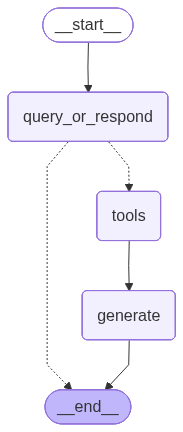

In [41]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
# input_message = "Hello"

# for step in graph.stream(
#     {"messages": [{"role": "user", "content": input_message}]},
#     stream_mode="values",
# ):
#     step["messages"][-1].pretty_print()

In [43]:
input_message = "What is the refund policy at Macquarie University?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the refund policy at Macquarie University?
Query_or_respond output: content='' additional_kwargs={'tool_calls': [{'id': 'call_wNoGYAUTNVsfkwkmXbG4fuDQ', 'function': {'arguments': '{"query":"Macquarie University refund policy tuition fees refunds international domestic courses withdrawal refund policy Macquarie University 2025"}', 'name': 'retrieve'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 136, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CGPMUOVXOi9wPM13nZ9gVkJCjM0Dp', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--7e22d25

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


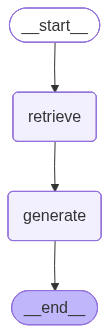

Context: [Document(id='doc-139', metadata={'url': 'https://connect.mq.edu.au/s/article/Refund-Request-International'}, page_content='11 Oct 2024\nKnowledge\nIf you are an international student and your account is in credit, you may be entitled to a refund if you are:\nin the last semester of your study\nwithdrawing completely from your course\ngiven special consideration\nBefore you begin\nCheck thekey dates\nEnsure you review theInternational fee refund policybefore applying\nRefer toRefund for International Studentsfor information on how to apply\nYou can find answers to frequently asked questions about refund for International students below.\n\nI have not started my studies; however, I want to apply for a refund.\nIf you have not commenced your study at Macquarie University, you can apply for a refund by completing theInternational withdrawal and release request form. Once completed, you can return this form and supporting documents to your International Admissions Officer.\n\nHow 

In [ ]:
from IPython.display import Image, display
from langgraph.graph import START, StateGraph
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

# assert len(example_messages) == 1
print(example_messages[0].content)

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    
    
def retrieve(state: State):
    """ Retrieve relevant documents from the vector store."""
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    """ Generate answer """
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke(
        {"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")